In [ ]:
import random
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust Model Structure Depends on the Data
num_classes = 2 # label 0~9: total 10 classes
in_channel = 1 # black and white images: 1 channel (RGB: 3 channels)

# Hyper-parameters
batch_size = 100
max_pool_kernel = 2
learning_rate = 0.0001
num_epochs = 3

In [ ]:
###Python Random Seed 고정###

SEED = 1234 # 원하는 seed값을 사용하시면 됩니다.

random.seed(SEED) # python에서 random 한 부분을 해당 seed값으로 고정합니다.
torch.manual_seed(SEED) # torch에서 random한 부분을 해당 seed값으로 고정합니다.
torch.cuda.manual_seed(SEED) # torch의 cuda연산에서 random한 부분을 해당 seed값으로 고정합니다.

class TypeData(Dataset):
  '''
### Digit일 경우 label로 0을, ###
### Letter일 경우 label로 1을 ###
### return하는 class입니다. ###
사용 예시:
train_data = TypeData(train=True)
test_data = TypeData(train=False)
  '''
  def __init__(self,train):
    super(TypeData, self).__init__()
    self.digit = 10
    self.letter = 46
    self.train = train

    self.data = torchvision.datasets.EMNIST(root='./',
                                        split='bymerge',
                                        train=self.train,
                                        transform=transforms.ToTensor(),
                                        download=True)

  def __getitem__(self, index):
    if self.data[index][1] < self.digit:
      label = 0.
    else:
      label = 1.
    return self.data[index][0], label

  def __len__(self):
    return len(self.data)

  # nn.CrossEntropyLoss()를 사용하는 경우, train 코드에서
  # labels = labels.to(device, dtype=long) 또는,
  # labels = labels.to(device).long() 과 같은 방법으로 data type을 변경하여 사용해 보세요.

### train 또는 test dataset에 대하여, num의 수만큼 subplot을 보여주는 함수입니다.
def image_show(dataset, num):
  fig = plt.figure(figsize=(30,30))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i][0].squeeze())
    plt.title(dataset[i][1])

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=TypeData(train=True),
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=TypeData(train=False),
                                           batch_size=batch_size,
                                           shuffle=True)

Extracting ./EMNIST/raw/emnist.zip to ./EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [ ]:
import torch.nn.functional as F
import torchsummary as summary #optional, to see model's summary

class ConvNet(nn.Module):
  def __init__(self, num_classes=1):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channel, 10, 3, stride=1, padding=1),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(10, 100, 3, stride=1, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.fc1 = nn.Linear(7*7*100, 512)
    self.fc2 = nn.Linear(512,128)
    self.fc3 = nn.Linear(128,32)
    self.fc4 = nn.Linear(32,num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0),-1)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = F.dropout(x,p=0.2)
    x = torch.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x
model = ConvNet(num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# cf) see network form
print(model)

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4900, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)
                       model summary                        
layer1.0.weight                  torch.Size([10, 1, 3, 3])   
layer1.0.bias                       

In [ ]:
total_step = len(train_loader)
loss_list = []

# Train
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Assign Tensors to Configured Device
    images = images.to(device)
    labels = labels.to(device).long()

    # Forward Propagation
    outputs = model(images)
    
    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    # Print Loss for Tracking Training

    if (i+1) % 1000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), '20151600_model1.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/3], Step[1000/6980], Loss:0.4756
Epoch [1/3], Step[2000/6980], Loss:0.4457
Epoch [1/3], Step[3000/6980], Loss:0.4164
Epoch [1/3], Step[4000/6980], Loss:0.4123
Epoch [1/3], Step[5000/6980], Loss:0.3958
Epoch [1/3], Step[6000/6980], Loss:0.4013
Epoch [2/3], Step[1000/6980], Loss:0.4416
Epoch [2/3], Step[2000/6980], Loss:0.4081
Epoch [2/3], Step[3000/6980], Loss:0.4160
Epoch [2/3], Step[4000/6980], Loss:0.3905
Epoch [2/3], Step[5000/6980], Loss:0.3575
Epoch [2/3], Step[6000/6980], Loss:0.4098
Epoch [3/3], Step[1000/6980], Loss:0.4280
Epoch [3/3], Step[2000/6980], Loss:0.3764
Epoch [3/3], Step[3000/6980], Loss:0.3489
Epoch [3/3], Step[4000/6980], Loss:0.4037
Epoch [3/3], Step[5000/6980], Loss:0.4263
Epoch [3/3], Step[6000/6980], Loss:0.3671


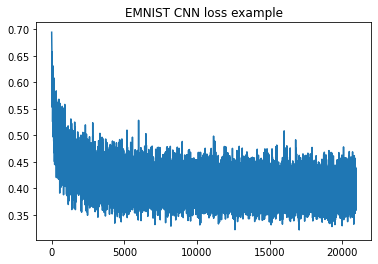

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("EMNIST CNN loss example")
plt.show()

In [ ]:
test_model = ConvNet(num_classes)
test_model.load_state_dict(torch.load("20151600_model1.pth"))

with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 100*correct/total))

Accuracy of the network on the 116400 test images 91.47116219492275%
